In [ ]:
# function ClickConnect(){
#     console.log("Working");
#     document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click()
# }
# setInterval(ClickConnect, 30000)

In [ ]:
# Mount Google Drive and go to correct directory
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
cd drive/"My Drive"/"Colab Notebooks"/master_project/HAN

/content/drive/My Drive/Colab Notebooks/master_project/HAN


In [ ]:
import os
import pickle
import random
import re
import string
import json
import sys
import matplotlib
import math

import keras
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import HTML, display
from keras import backend as K
from keras import constraints
from keras import initializers as initializers
from keras import optimizers, regularizers
from keras.callbacks import *
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.layers import (GRU, LSTM, Activation, Bidirectional, Concatenate,
                          Dense, Dropout, Embedding, Flatten, Input, Lambda,
                          Layer, Reshape, SpatialDropout1D, TimeDistributed,
                          concatenate)
from keras.models import Model
from keras.optimizers import SGD, Adam, RMSprop
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.utils import to_categorical
from keras.utils.np_utils import to_categorical
from nltk import tokenize
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score)
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.decomposition import PCA

from clr_callback import *

nltk.download("punkt")

sys.path.append('..')
from utilities import *

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### Config

In [ ]:
max_features=100000
max_senten_len=100
max_senten_num=1
embed_size=300
path_to_save = 'models/model1/'

### Data

In [ ]:
# Load in the data
df_all = pd.read_pickle('df_all.pkl')

In [ ]:
 # Check which POS there are
pos_set = set()
def check_pos_cat(sent):
    for pos in sent.split():
        pos_set.add(pos)
df_all.pos.apply(check_pos_cat)

0         None
1         None
2         None
3         None
4         None
          ... 
799995    None
799996    None
799997    None
799998    None
799999    None
Name: pos, Length: 800000, dtype: object

In [ ]:
# Instantiate POS dict
pos_convert_dict = {}
for i, pos in enumerate(list(pos_set)):
    pos_convert_dict[pos.lower()] = i

In [ ]:
# One-hot encode the different POS
pos_arr = np.array([pos_convert_dict[p.lower()] for p in pos_set])
pos_onehot = to_categorical(pos_arr, num_classes=len(pos_set))

In [ ]:
# POS dict with as key the POS-tag and as value its one-hot encoded representation
for key, value in pos_convert_dict.items():
    pos_convert_dict[key.lower()] = pos_onehot[value]

In [ ]:
def clean_str(string):
    """
    Tokenization/string cleaning for dataset
    Every dataset is lower cased except
    """
    string = re.sub(r"\\", "", string)    
    string = re.sub(r"\'", "", string)    
    string = re.sub(r"\"", "", string)    
    return string.strip().lower()

In [ ]:
# Inspect finalized DataFrame
df_all.head()

,words,categories,is_which_set,pos
0,i figured betty crocker would make a great cake,0,train,PRON VERB ADJ NOUN AUX VERB DET ADJ NOUN
1,i was offered the opportunity to taste this pr...,0,train,PRON VERB VERB DET NOUN PART VERB DET NOUN ADP...
2,it is small and hard to depress when wearing f...,0,train,PRON VERB ADJ CCONJ ADJ PART VERB ADV VERB ADJ...
3,the grids do not remove but are easy to wipe d...,1,train,DET NOUN VERB ADV VERB CCONJ VERB ADJ PART VER...
4,i mean no secret characters and you change you...,0,train,PRON VERB DET ADJ NOUN CCONJ PRON VERB PRON NO...


In [ ]:
def create_index(data):
    '''
    Tokenization of the input and index creation
    '''
    paras, texts = [], []
    sent_lens, sent_nums = [], []
    for idx in range(data.shape[0]):
        text = clean_str(data[idx])
        texts.append(text)
        sentences = tokenize.sent_tokenize(text)
        sent_nums.append(len(sentences))
        for sent in sentences:
            sent_lens.append(len(text_to_word_sequence(sent)))
        paras.append(sentences)

    tokenizer = Tokenizer(num_words=max_features, oov_token=True)
    tokenizer.fit_on_texts(texts)

    data = np.zeros((len(texts), max_senten_num, max_senten_len), dtype="int32")
    for i, sentences in enumerate(paras):
        for j, sent in enumerate(sentences):
            if j< max_senten_num:
                wordTokens = text_to_word_sequence(sent)
                k=0
                for _, word in enumerate(wordTokens):
                    try:
                        if k<max_senten_len and tokenizer.word_index[word]<max_features:
                            data[i,j,k] = tokenizer.word_index[word]
                            k=k+1
                    except:
                        print(word)
                        pass

    return data, tokenizer.word_index


def preprocess(df, show_plots=False):
    '''
    Create the inputs for the model and separate the train and development sets
    '''
    # df = shuffle(df)
    # df.reset_index(inplace=True, drop=True)
    df["text"] = df["words"] 

    df = df[["text", "categories", "is_which_set", "pos"]]

    text = df["text"]
    pos = df["pos"]
    labels = pd.get_dummies(df["categories"])
    is_set =  pd.get_dummies(df["is_which_set"])

    train_indices = is_set.index[is_set["train"] == 1].tolist()
    val_indices = is_set.index[is_set["val"] == 1].tolist()
    test_indices = is_set.index[is_set["test"] == 1].tolist()

    cates = df.groupby("categories")
    print("Total sentiment categories:", cates.ngroups)
    print(cates.size())

    data, word_index = create_index(df.text)
    print("Total %s unique word tokens." % len(word_index))

    pos_data, pos_index = create_index(df.pos)
    print("Total %s unique POS tokens." % len(pos_index))

    print("Shape of data tensor:", data.shape)
    print("Shape of POS tensor:", pos_data.shape)
    print("Shape of labels tensor:", labels.shape)

    x_train, y_train, pos_train, x_val, y_val, pos_val, x_test, y_test, pos_test = (data, labels, pos_data)*3

    x_train = np.delete(x_train, test_indices+val_indices, axis=0)
    x_val = np.delete(x_val, train_indices+test_indices, axis=0)
    x_test = np.delete(x_test, train_indices+val_indices, axis=0)

    y_train = y_train.iloc[train_indices]
    y_val = y_val.iloc[val_indices]
    y_test = y_test.iloc[test_indices]

    pos_train = np.delete(pos_train, val_indices+test_indices, axis=0)
    pos_val = np.delete(pos_val, train_indices+test_indices, axis=0)
    pos_test = np.delete(pos_test, train_indices+val_indices, axis=0)

    return x_train, y_train, pos_train, x_val, y_val, pos_val, x_test, y_test, pos_test, is_set, word_index, pos_index

In [ ]:
try:
    with open("fully_processed.pickle", "rb") as handle:
        x_train, y_train, pos_train, x_val, y_val, pos_val, x_test, y_test, pos_test, is_set, word_index, pos_index = pickle.load(handle)
except FileNotFoundError as e:
    x_train, y_train, pos_train, x_val, y_val, pos_val, x_test, y_test, pos_test, is_set, word_index, pos_index = preprocess(df_all)
    fully_processed = (x_train, y_train, pos_train, x_val, y_val, pos_val, x_test, y_test, pos_test, is_set, word_index, pos_index)
    with open("fully_processed.pickle", "wb") as handle:
        pickle.dump(fully_processed, handle, protocol=pickle.HIGHEST_PROTOCOL)

Total sentiment categories: 2
categories
0    400000
1    400000
dtype: int64
Total 66480 unique word tokens.
Total 17 unique POS tokens.
Shape of data tensor: (800000, 1, 100)
Shape of POS tensor: (800000, 1, 100)
Shape of labels tensor: (800000, 2)


In [ ]:
print('Number of positive and negative reviews in training, test and validation set\n')
print("\t\tNegative\tPositive")
print("",*y_train.columns.tolist(), sep="\t\t")
print("Train:",*y_train.sum(axis=0).tolist(), sep="\t\t")
print("Val:",*y_val.sum(axis=0).tolist(), sep="\t\t")
print("Test:",*y_test.sum(axis=0).tolist(), sep="\t\t")

Number of positive and negative reviews in training, test and validation set

		Negative	Positive
		0		1
Train:		300000		300000
Val:		50000		50000
Test:		50000		50000


# Model

## Attention Layer

In [ ]:
# Adapted from https://gist.github.com/cbaziotis/7ef97ccf71cbc14366835198c09809d2
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatibl|e with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)

class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape=(input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

## Model Creation

In [ ]:
# Regularization to reduce overfitting
REG_PARAM = 1e-13
l2_reg = regularizers.l2(REG_PARAM)

In [ ]:
# Load in the pre-trained word embeddings (GloVe)
# EMBEDDING_DIR = "glove.twitter.27B.200d.txt"
# embeddings_index = {}
# f = open(EMBEDDING_DIR)
# for line in f:
#     try:
#         values = line.split()
#         word = values[0]
#         coefs = np.asarray(values[1:], dtype='float32')
#         embeddings_index[word] = coefs
#     except:
#         print(word)
#         pass
# f.close()
# print('Total %s word vectors.' % len(embeddings_index))

In [ ]:
# Load in the pre-trained word embeddings (Sentiment-aware embeddings)
embedding_name = "SKIP_negative10_EN_Change_inputSentiment_weightsum.p"
embeddings_index = pickle.load(open(embedding_name,"rb"))

In [ ]:
# Ensure the set embedding size is correct
assert embed_size == embeddings_index["the"].shape[0] 

In [ ]:
# Initialize the embedding matrix and fill it with known word vectors (or zero-vector for unknown words)
embedding_name = embedding_name.split(".")[0]
try:
    with open(embedding_name+"_embedding_matrix.pickle", "rb") as handle:
        embedding_matrix = pickle.load(handle)
except FileNotFoundError as e:
    embedding_matrix = np.zeros((len(word_index) + 1, embed_size))
    absent_words = -1 # First thing in the index is always True, instead of a word, so don't count it
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
        else:
            absent_words += 1
    print('Total absent words are', absent_words, 'which is', "%0.2f" % (absent_words * 100 / len(word_index)), '% of total words')
    with open(embedding_name+"_embedding_matrix.pickle", "wb") as handle:
        pickle.dump(embedding_matrix, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Initialize the POS embedding matrix and fill it with known word vectors (or zero-vector for unknown words)
try:
    with open("pos_embedding_matrix.pickle", "rb") as handle:
        pos_embedding_matrix = pickle.load(handle)
except FileNotFoundError as e:        
    pos_embedding_matrix = np.zeros((len(pos_index) + 1, len(pos_set)))
    absent_pos = -1
    for pos, i in pos_index.items():
        embedding_vector = pos_convert_dict.get(pos)
        if embedding_vector is not None:
            # POS not found in embedding index will be all-zeros.
            pos_embedding_matrix[i] = embedding_vector
        else:
            absent_pos += 1
    print('Total absent POS are', absent_pos, 'which is', "%0.2f" % (absent_pos * 100 / len(pos_index)), '% of total POS')
    with open("pos_embedding_matrix.pickle", "wb") as handle:
        pickle.dump(pos_embedding_matrix, handle, protocol=pickle.HIGHEST_PROTOCOL)    

In [ ]:
embedding_layer = Embedding(len(word_index) + 1, embed_size, weights=[embedding_matrix], input_length=max_senten_len, trainable=False)

In [ ]:
embedding_pos = Embedding(len(word_index) + 1, len(pos_set), input_length=max_senten_len, trainable=False)

In [ ]:
# Individual parts of the model

# Combined input has the shape => number of inputs * MAX_SENT_LENGTH
# NOTE: The seperation of individual inputs only works when num_inputs = 2, use different seperation method if more inputs are used
num_inputs = 2 
combined_input = Input(shape=(num_inputs*max_senten_len,), dtype='float32')
# Seperate word input
word_input = Lambda(lambda x: x[:, 0:max_senten_len])(combined_input)
# Get the word-embeddings
word_sequences = embedding_layer(word_input)
# Seperate the POS input
pos_input = Lambda(lambda x: x[:, max_senten_len: ])(combined_input)
# print(word_sequences.shape)
pos_shaped = embedding_pos(pos_input)
# print(pos_shaped.shape)
# Concatenate the word embeddings with our POS-vectors
merged = Concatenate()([word_sequences, pos_shaped])

word_lstm = Bidirectional(LSTM(150, return_sequences=True, kernel_regularizer=l2_reg))(merged)
word_dense = TimeDistributed(Dense(200, kernel_regularizer=l2_reg))(word_lstm)
word_att = AttentionWithContext()(word_dense)
wordEncoder = Model(inputs=combined_input, outputs=word_att)

sent_input = Input(shape=(max_senten_num, num_inputs*max_senten_len), dtype='float32')
sent_encoder = TimeDistributed(wordEncoder)(sent_input)
sent_lstm = Bidirectional(LSTM(150, return_sequences=True, kernel_regularizer=l2_reg))(sent_encoder)
sent_dense = TimeDistributed(Dense(200, kernel_regularizer=l2_reg))(sent_lstm)
sent_att = Dropout(0.5)(AttentionWithContext()(sent_dense))
preds = Dense(len(set(y_train)), activation='softmax')(sent_att)
model = Model(sent_input, preds)

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1, 200)            0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 1, 200)            21668996  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 1, 300)            421200    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 1, 200)            60200     
_________________________________________________________________
attention_with_context_2 (At (None, 200)               40400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 402 

In [ ]:
# Combine Normal+POS input

# np.array([[1,2],[1,3]])  
# np.array([[4,5],[6,1]])  
# with np.concatenate   Becomes =>  np.array([[1,2],[1,3],[4,5],[6,1]])  
# with np.c_            Becomes =>  np.array([[1,2,4,5],[1,3,6,1]])  

x_input = np.c_[x_train, pos_train]
val_input = np.c_[x_val, pos_val]
test_input = np.c_[x_test, pos_test]

In [ ]:
# Visualize embeddings PCA
get_doc_embeddings = Model(sent_input,sent_att)

docs = test_input[:1000]
labels = [i.index(1) for i in y_test.values.tolist()][:1000]

doc_emb_dim = 200
doc_embs = np.empty((0,doc_emb_dim))
for idx, doc in enumerate(docs):
    doc = doc.reshape(1, 1, doc_emb_dim)
    doc_emb = get_doc_embeddings.predict(doc)
    doc_embs = np.append(doc_embs,doc_emb,axis=0)
    if idx in split_into_parts(len(docs), 10):
        print(f"Progress: {idx}/{len(docs)}")

my_pca = PCA(n_components=2)
doc_embs_pca = my_pca.fit_transform(doc_embs)

my_colors = ['#0055a4','#ff0000']
fig, ax = plt.subplots()
for label in list(set(labels)):
    idxs = [idx for idx, x in enumerate(labels) if x==label]
    ax.scatter(doc_embs_pca[idxs,0], 
               doc_embs_pca[idxs,1], 
               c = my_colors[label],
               label=str(label),
               alpha=0.7,
               s=10)

ax.legend(scatterpoints=1)
fig.set_size_inches(12, 8)
fig.suptitle('PCA visualization of doc embeddings BEFORE training',fontsize=14)
fig.savefig(path_to_save+"/PCA_before.png", facecolor='w', edgecolor='w',
        orientation='portrait', format="png",
        transparent=True, bbox_inches="tight", pad_inches=0.1)
fig.show()

## Learning Rate Range Test

Adapted from https://github.com/Tixierae/deep_learning_NLP/

In [ ]:
model.save_weights(path_to_save + 'han_init_weights')

In [ ]:
# epochs = 5
# training_items = 600000
# batch_size = 5000
# iterations = 600000/5000 = 120
# step_size = iterations * epochs = 120 * 5 = 600
base_lr, max_lr = 1e-7, 1e-1
epoch_amount = 5

model.compile(loss='categorical_crossentropy', optimizer=Adam(base_lr, amsgrad=True), metrics=['acc'])

lr_sch = CyclicLR(base_lr=base_lr, 
                  max_lr=max_lr, 
                  step_size = 120*epoch_amount,
                  mode='triangular')

In [ ]:
model.fit(x=x_input, y=y_train, epochs=epoch_amount, batch_size=5000, callbacks=[lr_sch])

Epoch 1/5
600000/600000 [==============================] - 77s 129us/step - loss: 0.5773 - acc: 0.6877
Epoch 2/5
600000/600000 [==============================] - 76s 126us/step - loss: 0.4559 - acc: 0.7862
Epoch 3/5
600000/600000 [==============================] - 76s 126us/step - loss: 0.4551 - acc: 0.7771
Epoch 4/5
600000/600000 [==============================] - 76s 126us/step - loss: 0.6932 - acc: 0.5006
Epoch 5/5
600000/600000 [==============================] - 75s 126us/step - loss: 0.6932 - acc: 0.4989


In [ ]:
# Save history of learning rate range test
hist = model.history.history
hist["lr"] = lr_sch.history["lr"]
hist["acc_step"] = lr_sch.history["acc"]
hist = {k: [str(par) for par  in v] for k, v in hist.items()}

with open(path_to_save + 'han_lr_range_test_history.json', 'w') as handle:
    json.dump(hist, handle, indent=4)

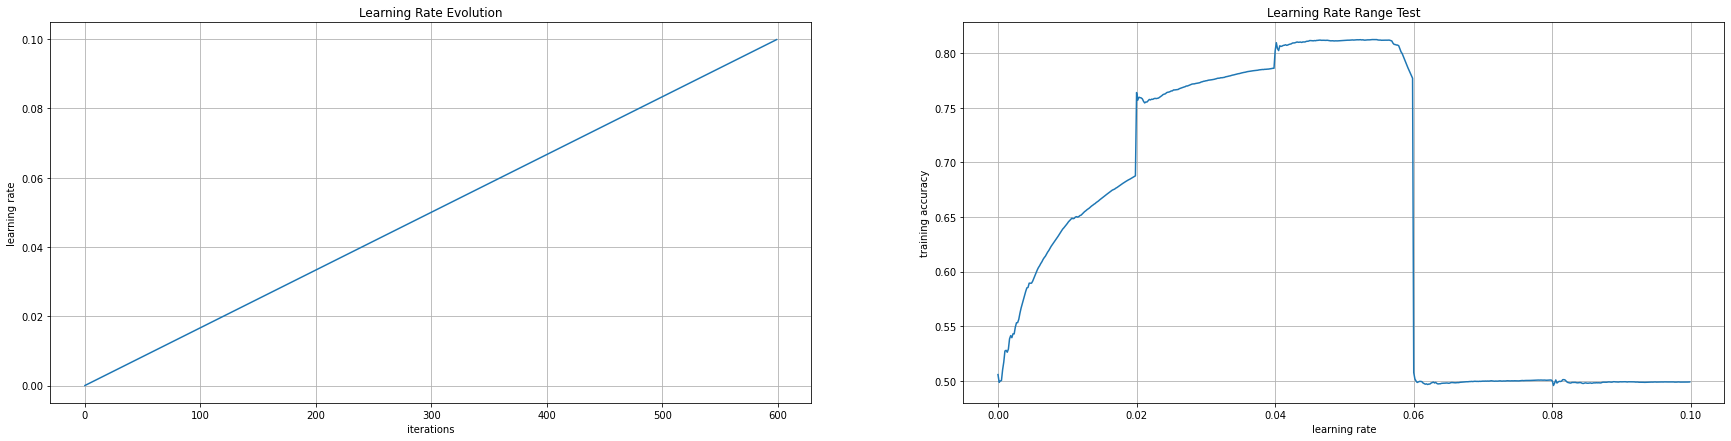

In [ ]:
with open(path_to_save + 'han_lr_range_test_history.json' , 'r', encoding='utf8') as handle:
    hist = json.load(handle)

hist = {k:list(map(float,v)) for k,v in hist.items()} 

fig = plt.figure(figsize=(30,7))

plt.subplot(1,2,1)
plt.plot(range(len(hist['lr'])),hist['lr'])
plt.xlabel('iterations')
plt.ylabel('learning rate')
plt.grid(True)
plt.title('Learning Rate Evolution')

plt.subplot(1,2,2)
plt.plot(hist["lr"], hist["acc_step"])
plt.xlabel('learning rate')
plt.ylabel('training accuracy')
plt.grid(True)
plt.title('Learning Rate Range Test')
plt.savefig(path_to_save+"/lr_range_test.png", facecolor='w', edgecolor='w',
        orientation='portrait', format="png",
        transparent=True, bbox_inches="tight", pad_inches=0.1)
plt.show()

best accuracy: 0.81253177
with learning rate: 0.054000046

base learning rate: 0.0108


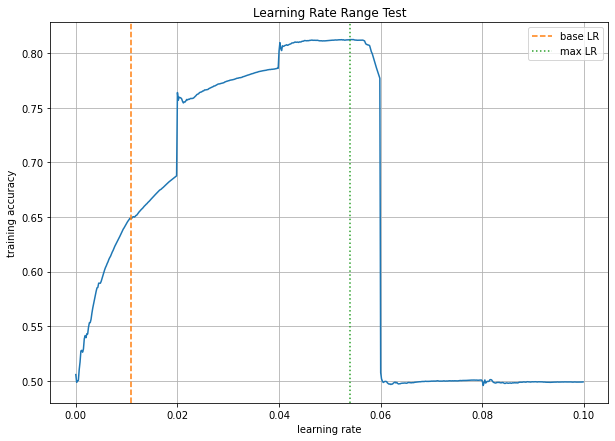

In [ ]:
# base learning rate set to max_lr/6 (https://arxiv.org/pdf/1506.01186.pdf)
max_lr =  hist["lr"][np.argmax(hist["acc_step"])]

print('best accuracy:',max(hist["acc_step"]))
print('with learning rate:',max_lr)
base_lr = round(max_lr/5, 5)
print('\nbase learning rate:',base_lr)

fig = plt.figure(figsize=(10,7))
plt.plot(hist["lr"],hist["acc_step"])
plt.xlabel('learning rate')
plt.ylabel('training accuracy')
plt.grid(True)
plt.title('Learning Rate Range Test')
plt.axvline(x=base_lr,label='base LR',c='C1',ls='dashed')
plt.axvline(x=max_lr,label='max LR',c='C2',ls='dotted')
plt.legend()
plt.savefig(path_to_save+"/lr_range_test_best.png", facecolor='w', edgecolor='w',
        orientation='portrait', format="png",
        transparent=True, bbox_inches="tight", pad_inches=0.1)
plt.show()

## Training the model


In [ ]:
# # Reinitialize model
# model.load_weights(path_to_save + 'han_init_weights')

In [ ]:
epoch_amount = 10
cycle = 2
half_cycle = cycle/2
my_patience = cycle
clr_triangular = CyclicLR(step_size=120*half_cycle, mode='triangular')
model.compile(loss='categorical_crossentropy',optimizer=Adam(base_lr, amsgrad=True),metrics=['acc'])

In [ ]:
# Stop model when validation accuracy no longer increases
early_stopping = EarlyStopping(monitor='val_acc', 
                               patience=my_patience,
                               mode='max')

# Setup model checkpoints
checkpoint = ModelCheckpoint(filepath = path_to_save + 'han_trained_weights',
                               monitor='val_acc',
                               save_best_only=True,
                               mode='max',
                               verbose=0,
                               save_weights_only=True)

In [ ]:
history = model.fit(x=x_input, y=y_train, validation_data=(val_input, y_val), epochs=epoch_amount, batch_size=5000, callbacks=[clr_triangular, early_stopping, checkpoint])

Train on 600000 samples, validate on 100000 samples
Epoch 1/10
600000/600000 [==============================] - 82s 137us/step - loss: 0.5912 - acc: 0.6752 - val_loss: 0.5273 - val_acc: 0.7315
Epoch 2/10
600000/600000 [==============================] - 80s 134us/step - loss: 0.4732 - acc: 0.7711 - val_loss: 0.4416 - val_acc: 0.7912
Epoch 3/10
600000/600000 [==============================] - 80s 134us/step - loss: 0.4412 - acc: 0.7917 - val_loss: 0.4420 - val_acc: 0.7934
Epoch 4/10
600000/600000 [==============================] - 80s 134us/step - loss: 0.4071 - acc: 0.8123 - val_loss: 0.3999 - val_acc: 0.8167
Epoch 5/10
600000/600000 [==============================] - 80s 134us/step - loss: 0.3931 - acc: 0.8204 - val_loss: 0.4065 - val_acc: 0.8122
Epoch 6/10
600000/600000 [==============================] - 80s 134us/step - loss: 0.3783 - acc: 0.8291 - val_loss: 0.3827 - val_acc: 0.8272
Epoch 7/10
600000/600000 [==============================] - 80s 134us/step - loss: 0.3625 - acc: 0.837

In [ ]:
model.save(path_to_save+"/"+str(epoch_amount)+"ep_word_pos.h5")

In [ ]:
# Save history
hist = history.history
hist["lr"] = clr_triangular.history["lr"]
hist["acc_step"] = clr_triangular.history["acc"]
hist = {k: [str(par) for par  in v] for k, v in hist.items()}
with open(path_to_save + 'han_history.json', 'w') as handle:
    json.dump(hist, handle, indent=4)

# Plotting

In [ ]:
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr', 'acc_step'])


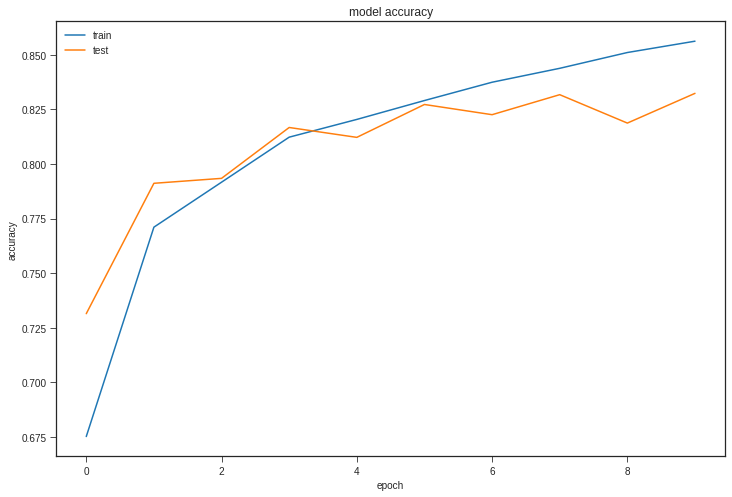

In [ ]:
#% matplotlib inline
from matplotlib import style
style.use('seaborn-ticks')

# summarize history for accuracy
plt.gcf().set_size_inches(12, 8)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(path_to_save+"/model_accuracy.png", facecolor='w', edgecolor='w',
        orientation='portrait', format="png",
        transparent=True, bbox_inches="tight", pad_inches=0.1)
plt.show()

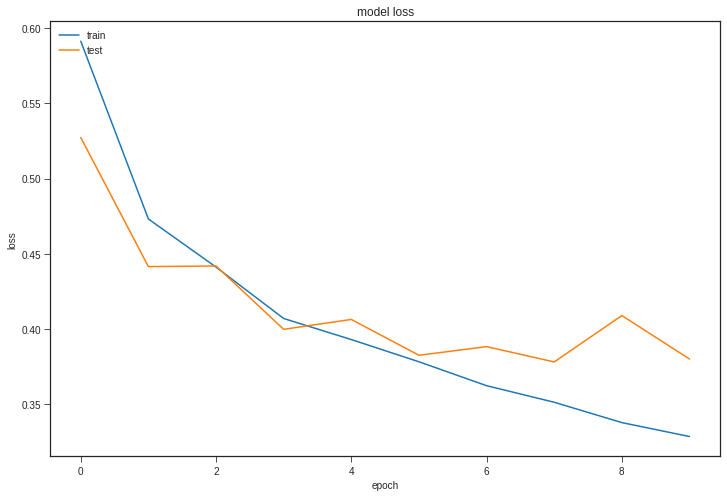

In [ ]:
# summarize history for loss
plt.gcf().set_size_inches(12, 8)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(path_to_save+"/model_loss.png", dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format="png",
        transparent=True, bbox_inches="tight", pad_inches=0.1)
plt.show()

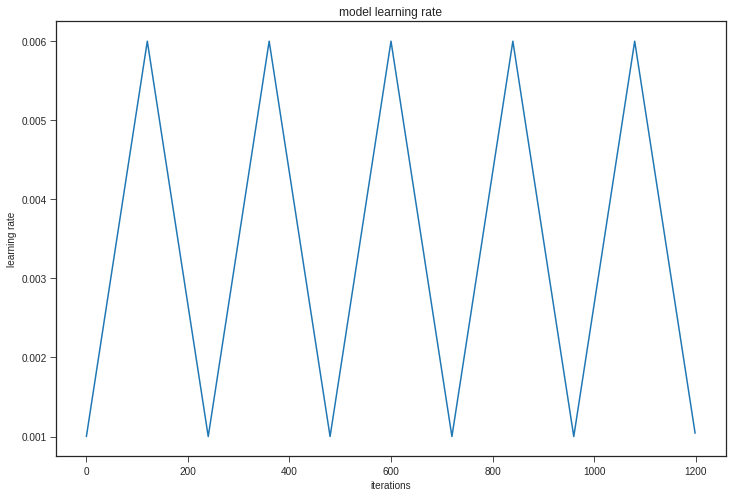

In [ ]:
plt.gcf().set_size_inches(12, 8)
plt.plot(range(len(history.history['lr'])), history.history['lr'])
plt.title('model learning rate')
plt.ylabel('learning rate')
plt.xlabel('iterations')
plt.savefig(path_to_save+"/model_learning_rate.png", dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format="png",
        transparent=True, bbox_inches="tight", pad_inches=0.1)
plt.show()

Progress: 1000/10000
Progress: 2000/10000
Progress: 3000/10000
Progress: 4000/10000
Progress: 5000/10000
Progress: 6000/10000
Progress: 7000/10000
Progress: 8000/10000
Progress: 9000/10000


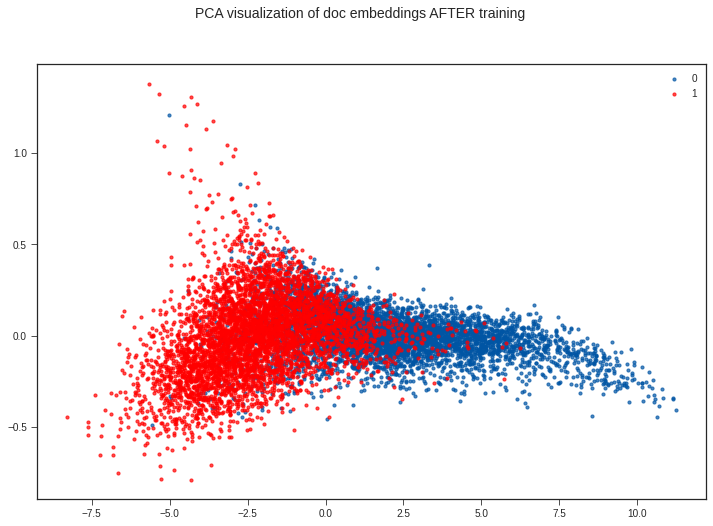

In [ ]:
# Try see embeddings with PCA after tranining
model.load_weights(path_to_save + 'han_trained_weights')

# get_doc_embeddings = Model(sent_input,sent_att)
get_doc_embeddings = Model(model.get_layer("input_2").input, model.get_layer("dropout_1").input)

docs = test_input[:1000]
labels = [i.index(1) for i in y_test.values.tolist()][:1000]

doc_emb_dim = 200
doc_embs = np.empty((0,doc_emb_dim))
for idx, doc in enumerate(docs):
    doc = doc.reshape(1, 1, doc_emb_dim)
    doc_emb = get_doc_embeddings.predict(doc)
    doc_embs = np.append(doc_embs,doc_emb,axis=0)
    if idx in split_into_parts(len(docs), 10):
        print(f"Progress: {idx}/{len(docs)}")

my_pca = PCA(n_components=2)
doc_embs_pca = my_pca.fit_transform(doc_embs)

fig, ax = plt.subplots()
my_colors = ['#0055a4','#ff0000']
for label in list(set(labels)):
    idxs = [idx for idx,elt in enumerate(labels) if elt==label]
    ax.scatter(doc_embs_pca[idxs,0], 
               doc_embs_pca[idxs,1], 
               c = my_colors[label],
               label=str(label),
               alpha=0.7,
               s=10)

ax.legend(scatterpoints=1)
fig.set_size_inches(12, 8)
fig.suptitle('PCA visualization of doc embeddings AFTER training',fontsize=14)
fig.savefig(path_to_save+"/PCA_after.png", facecolor='w', edgecolor='w',
        orientation='portrait', format="png",
        transparent=True, bbox_inches="tight", pad_inches=0.1)
fig.show()

In [ ]:
def create_custom_objects():
    instance_holder = {"instance": None}

    class ClassWrapper(AttentionWithContext):
        def __init__(self, *args, **kwargs):
            instance_holder["instance"] = self
            super(ClassWrapper, self).__init__(*args, **kwargs)

    def loss(*args):
        method = getattr(instance_holder["instance"], "loss_function")
        return method(*args)

    def accuracy(*args):
        method = getattr(instance_holder["instance"], "accuracy")
        return method(*args)

    return {"ClassWrapper": ClassWrapper ,"AttentionWithContext": ClassWrapper, "loss": loss,
            "accuracy":accuracy, "max_senten_len": max_senten_len}

# Evaluation

In [ ]:
loaded_model = keras.models.load_model(path_to_save + '10ep_word_pos.h5', custom_objects=
                                       {"AttentionWithContext": AttentionWithContext, "max_senten_len": max_senten_len})
# loaded_model = keras.models.load_model('models/HAN_5epochs_word_pos.h5', custom_objects=create_custom_objects())

In [ ]:
loaded_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1, 200)            0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 1, 200)            21668996  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 1, 300)            421200    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 1, 200)            60200     
_________________________________________________________________
attention_with_context_2 (At (None, 200)               40400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 402 

100000/100000 [==============================] - 5s 47us/step
              precision    recall  f1-score   support

           0       0.84      0.82      0.83     50000
           1       0.82      0.85      0.83     50000

    accuracy                           0.83    100000
   macro avg       0.83      0.83      0.83    100000
weighted avg       0.83      0.83      0.83    100000



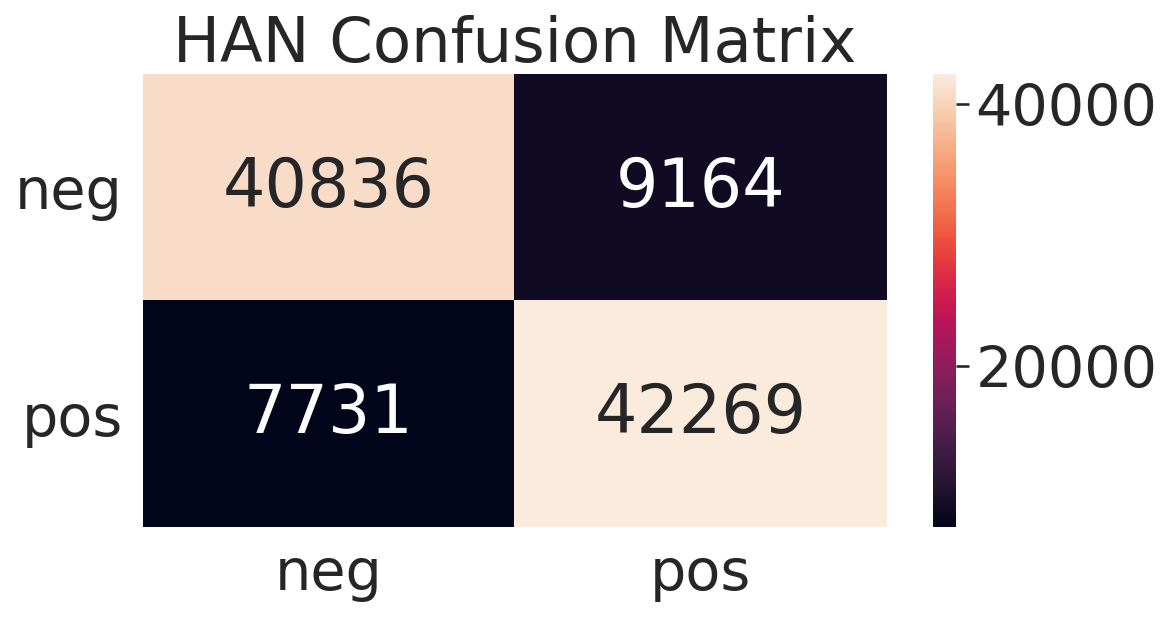

In [ ]:
y_pred = loaded_model.predict(test_input, batch_size=10000, verbose=1)
y_pred_r = np.argmax(y_pred, axis=1)

y_test_c = [i.index(1) for i in y_test.values.tolist()]

print(classification_report(y_test_c, y_pred_r))

confusion_m = np.zeros(shape=(len(set(y_test_c)),len(set(y_test_c))))
confusion_m = np.add(confusion_m, confusion_matrix(y_test_c, y_pred_r, labels = [0,1]))

create_confusion_matrix(confusion_m, ["neg","pos"], dir=path_to_save, y_lim_value=2.0, title="HAN", show_plots=True, save_plots=True, method="TESTING", fig_size=(8,4))